In [31]:
import numpy as np
import matplotlib.pyplot as plt
import ompy as om
import logging
import pandas as pd
import json

import scipy as sp
#%matplotlib widget
from ipywidgets import widgets #interact, interactive, fixed, interact_manual

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
om.__full_version__;
# For reproducability we seed the random generator.
# Note that by default several other classes in ompy, such as all
# classes with multinest calculations have a default seed, too
np.random.seed(1382398)

In [3]:
plt.rcParams["figure.dpi"] = 80
plt.rcParams["errorbar.capsize"] = 5
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['font.size'] = 25
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.major.size'] = 12
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 1.5

Import $\gamma$SF and NLD from Oslo Method

In [4]:
gsf_file = pd.read_csv('/home/tellefs/Documents/master/oslo_method_U233/strength.nrm')
gsf_file = gsf_file[(gsf_file.T != 0).any()]
gsf_om, gsf_om_error = np.split(np.asarray(gsf_file), 2)

nld_file = pd.read_csv('/home/tellefs/Documents/master/oslo_method_U233/rhopaw.cnt')
nld_file = nld_file[(nld_file.T != 0).any()]
nld_om, nld_om_error = np.split(np.asarray(nld_file), 2)



#from oslo method normalization
a0 = -0.8671
a1 = 0.1037
energy_gsf_om = np.linspace(999.9, 5252, len(gsf_om))
energy_nld_om = np.linspace(0, 5252-999.9, len(nld_om))
for i in range(len(gsf_om)):
    energy_gsf_om[i] = ((a0 + a1*energy_gsf_om[i])*1e1)*1e-3
for i in range(len(nld_om)):
    energy_nld_om[i] = ((a0 + a1*energy_nld_om[i])*1e1)*1e-3  



strength_nrm_d = np.genfromtxt("/home/tellefs/Documents/master/oslo_method_U233/strength.nrm")
gsf_om = strength_nrm_d[18:60]
gsf_om_error = strength_nrm_d[79:-1]
n_d = len(gsf_om)

#energy_gsf_om = np.zeros(n_d)
#for i in range(n_d):
#    energy_gsf_om[i] = a0 + a1*i    
    

Import $\gamma$SF and NLD from OmPy

In [5]:
def getMedianQuantile(func):
    func = pd.DataFrame(func)
    func_median = pd.DataFrame.median(func)
    func_error_low = func.quantile(0.16)
    func_error_high = func.quantile(0.84)
    func_error = func_error_high - func_error_low
    return func_median, func_error

def read_ompy(path):
    """
    path must not include / at the end
    """
    energy_gsf = pd.read_csv(path+'/gsf_0.txt', sep=" ", header=None, skiprows=[0])[0]*1e-3
    energy_nld = pd.read_csv(path+'/nld_0.txt', sep=" ", header=None, skiprows=[0])[0]*1e-3
    gsf = np.zeros((99, len(energy_gsf)))
    nld = np.zeros((99, len(energy_nld)))
    
    for i in range(99):
        if i != 76:
            gsf[i] = pd.read_csv(path+'/gsf_%.0i.txt'%i, sep=" ", header=None, skiprows=[0])[1]
            nld[i] = pd.read_csv(path+'/nld_%.0i.txt'%i, sep=" ", header=None, skiprows=[0])[1]
    
    gsf_median, gsf_error = getMedianQuantile(gsf)
    nld_median, nld_error = getMedianQuantile(nld)
    
    return energy_gsf, gsf_median, gsf_error, energy_nld, nld_median, nld_error

path = '/home/tellefs/Documents/master/OmPy_233U/normalized_data/ensemble_simnorm_nld_gsf_250_kevperbin'

energy_gsf_ompy, gsf_ompy_median, gsf_ompy_error, energy_nld_ompy, nld_ompy_median, nld_ompy_error = read_ompy(path)

Import and convert experimental data from EXFOR

In [80]:
with open('U233_exp_data.json') as K:
    data_U233 = json.load(K)
datasets_U233=data_U233["datasets"]


def cs_to_gsf(Eg, data):
    # input in MeV and milibarn -> use this conversion factor.
    exp = 8.684e-8# DOBBELTSJEKK TALLET! # pi**2 * hbar**2 * c**2
    return data*exp/Eg

def extract_JSON(data, x_i,y_i,yerror_i):
    """ Extracting data from input files from MAMA, adding them to useful arrays."""
    x = []; y = [] ; yerror = []

    for j in range(len(data)):
        y.append(list(data[j].values())[y_i]) # MeV
        yerror.append(list(data[j].values())[yerror_i]) # MeV
        x.append(list(data[j].values())[x_i])

    x = np.array(x) ; y = np.array(y) ; yerror = np.array(yerror)
    return x,y,yerror

energy_exp1, gsf_exp1, gsf_exp1_error =  extract_JSON(datasets_U233[0]['dataPoints'], 0, 2, 3)
gsf_exp1 = cs_to_gsf(energy_exp1, gsf_exp1)
gsf_exp1_error = cs_to_gsf(energy_exp1, gsf_exp1_error)

display(energy_exp1)


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

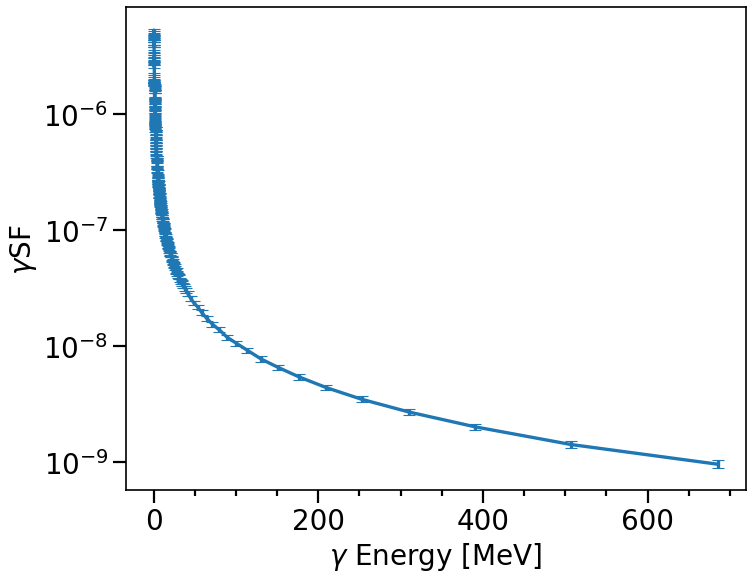

In [79]:
fig, ax = plt.subplots()
#ax.errorbar(x=energy_gsf_om, y=gsf_om, yerr=gsf_om_error, marker='o', linestyle='')
#ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, marker='o', linestyle='')

ax.errorbar(energy_exp1, gsf_exp1, yerr=gsf_exp1_error, x_err=None)#, fmt="*-", color="#CA5518", label="187Re(g,x)")


#ax.set_ylim(1e-9, 2e-6)
ax.set_yscale('log')
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlabel('$\gamma$ Energy [MeV]')
ax.set_ylabel('$\gamma$SF')

fig.show()

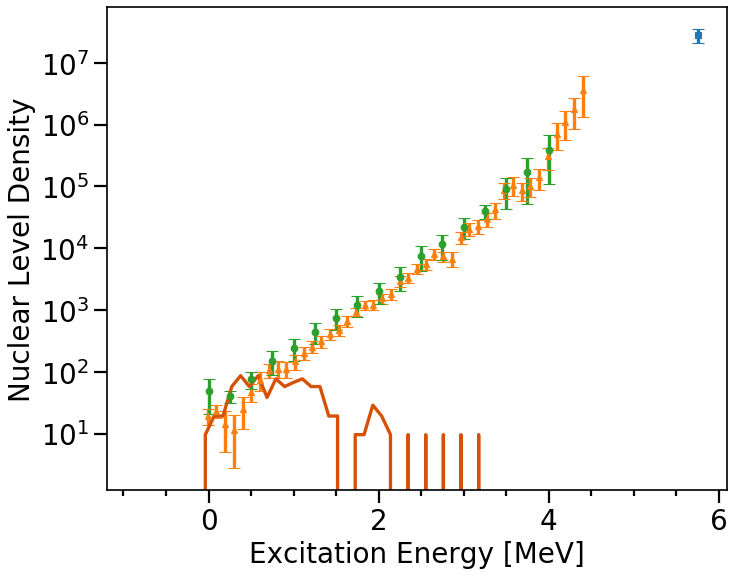

In [29]:


Sn = 5.762
rhoSn = 28.07e6
rhoSn_error = 7.02e6


#import discrete levels and plot as done in mama
discrete_levels_mama = np.genfromtxt('/home/tellefs/Documents/master/oslo_method_U233/rholev.cnt')
a0 =  -0.8671
a1 =   0.1037
n = 100
energy = a0 + a1*np.linspace(0,n-1,n)



fig, ax = plt.subplots()
ax.errorbar(x=Sn, y=rhoSn, yerr=rhoSn_error, marker='s', linestyle='')
ax.errorbar(x=energy_nld_om, y=nld_om, yerr=nld_om_error, marker='^', linestyle='')
ax.errorbar(x=energy_nld_ompy, y=nld_ompy_median, yerr=nld_ompy_error, marker='o', linestyle='')
ax.set_yscale('log')

plt.plot(energy[:len(discrete_levels_mama)], discrete_levels_mama, color="#D65108", label="Known levels")

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlabel('Excitation Energy [MeV]')
ax.set_ylabel('Nuclear Level Density')

fig.show()
